In [1]:
# -*- coding: utf-8 -*-
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import numpy as np # Can't install NumPy 2.2.2 which is what the pkls were saved with
import pandas as pd # 'v2.2.3'
# import anndata as ad
from scipy.spatial.distance import (
    pdist,
    squareform,
)
from pyexeggutor import (
    build_logger,
    write_pickle,
    read_pickle,
    check_argument_choice,
    format_header,
)

from sklearn.metrics import (
    pairwise_distances,
    silhouette_score,
)
import ensemble_networkx as enx
import igraph as ig
import optuna
import joblib

# Metabolic Niche Space
from metabolic_niche_space.neighbors import (
    convert_distance_matrix_to_kneighbors_matrix,
)
from metabolic_niche_space.utils import (
    compile_parameter_space,
)


# Metabolic Niche Space
from metabolic_niche_space.neighbors import (
    KNeighborsLeidenClustering,
    pairwise_distances_kneighbors,
)

/home/ec2-user/SageMaker/environments/mns/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
# Data
df_quality = pd.read_csv("../data/quality.tsv.gz",sep="\t", index_col=0)

quality_label="completeness_gte90.contamination_lt5"
# quality_label="completeness_gte50.contamination_lt10"
output_directory=f"../data/cluster/mfc/{quality_label}"
os.makedirs(output_directory, exist_ok=True)

genome_to_clusterani = pd.read_csv(f"../data/training/{quality_label}/y.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0].astype("category")
X_genomic_traits = pd.read_csv(f"../data/training/{quality_label}/X.tsv.gz", sep="\t", index_col=0).astype(bool)
X_genomic_traits_clusterani = pd.read_csv(f"../data/training/{quality_label}/X_grouped.tsv.gz", sep="\t", index_col=0).astype(bool)
# eukaryotes = read_list(f"../data/cluster/ani/eukaryotic/{quality_label}/organisms.list", set)
# prokaryotes = read_list(f"../data/cluster/ani/prokaryotic/{quality_label}/organisms.list", set)

genome_to_taxonomy = pd.read_csv("../data/taxonomy.tsv.gz", sep="\t", index_col=0).iloc[:,0]
clusterani_to_taxonomy = pd.read_csv("../data/cluster/ani/cluster-ani_to_taxonomy.tsv.gz", sep="\t", index_col=0, header=None).iloc[:,0]
df_meta_mfc__genomes = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genomes.with_openai.tsv.gz", sep="\t", index_col=0)
df_meta_mfc__slc = pd.read_csv(f"../data/cluster/mfc/{quality_label}/identifier_mapping.mfc.genome_clusters.with_openai.tsv.gz", sep="\t", index_col=0)

X_genomic_traits_mfc = X_genomic_traits_clusterani.groupby(df_meta_mfc__slc["id_cluster-mfc"]).sum() > 0
df_kegg = pd.read_csv("/home/ec2-user/SageMaker/s3/newatlantis-raw-veba-db-prod/VDB_v8.1/Annotate/KOfam/kegg-ortholog_metadata.tsv", sep="\t", index_col=0)
ko_to_description = df_kegg["definition"]

print("Number of genomes: {}, Number of features: {}, Number of SLCs: {}".format(*X_genomic_traits.shape, X_genomic_traits_clusterani.shape[0]))
# Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719

# CPU times: user 3.41 s, sys: 87.8 ms, total: 3.5 s
# Wall time: 3.5 s

Number of genomes: 20377, Number of features: 2124, Number of SLCs: 6719
CPU times: user 22.6 s, sys: 1.51 s, total: 24.1 s
Wall time: 25.5 s


In [35]:
def is_square_symmetric(matrix, tol=1e-8):
    """Check if a matrix is square and symmetric."""
    matrix = np.array(matrix)  # Ensure it's a NumPy array
    return matrix.shape[0] == matrix.shape[1] and np.allclose(matrix, matrix.T, atol=tol)

def stop_when_exceeding_trials(n_trials, logger):
    def callback(study, trial):
        """
        Callback that stops optimization if the total number of trials exceeds `n_trials`.
        """
        finished_trial_states = [
            optuna.trial.TrialState.COMPLETE, 
            optuna.trial.TrialState.FAIL, 
            optuna.trial.TrialState.RUNNING,
        ]

        total_completed_trials = sum(1 for t in study.trials if t.state in finished_trial_states)

        if total_completed_trials >= n_trials:
            logger.warning(f"[Callback] Stopping optimization: {total_completed_trials} trials reached (limit={n_trials})")
            study.stop()
    
    return callback  # Return the function with access to `n_trials` and `logger`
                  

class KNeighborsLeidenClustering(object):
    def __init__(
        self, 
        # General
        name:str=None,
        observation_type:str=None,
        feature_type:str=None,
        class_type:str=None,
        method:str = "one_minus",
        initial_distance_metric:str="precomputed",
        scoring_distance_metric:str="euclidean",
        n_neighbors:int="auto",
        
        # Community detection
        n_iter=10, 
        converge_iter=-1,
        minimum_membership_consistency=1.0, 
        cluster_prefix="c",
        
        # Optuna
        n_trials=10,
        n_jobs:int=1,
        n_concurrent_trials:int=1,
        initial_params:dict = None,
        objective_direction="maximize",
        checkpoint_directory=None,
        study_timeout=None,
        study_callbacks=None,
        random_state=0,
        verbose=1,
        stream=sys.stdout,
        ):
        
        # General
        if name is None:
            name = str(uuid.uuid4())
            
        self.name = name
        self.observation_type = observation_type
        self.feature_type = feature_type
        self.class_type = class_type        
        self.method = method
        self.initial_distance_metric = initial_distance_metric
        self.scoring_distance_metric = scoring_distance_metric
        
        # Community detection
        self.n_iter=n_iter
        self.converge_iter=converge_iter
        self.minimum_membership_consistency=minimum_membership_consistency
        self.cluster_prefix = cluster_prefix
        
        # Optuna
        self.n_jobs = n_jobs
        self.n_trials = n_trials
        self.n_concurrent_trials = n_concurrent_trials
        self.initial_params = initial_params
        self.checkpoint_directory = checkpoint_directory
        self.random_state = random_state
        self.study_timeout = study_timeout
        if study_callbacks is None:
            study_callbacks = []
        self.study_callbacks = study_callbacks
        self.objective_direction = objective_direction

        # Hyperparameters
        self.is_tuned = True
        if n_neighbors == "auto":
            n_neighbors = [int, 10, 100]
            self.is_tuned = False
        if isinstance(n_neighbors, list):
            self.is_tuned = False
        self.n_neighbors = n_neighbors
        
        self._param_space = dict(
            n_neighbors = self.n_neighbors,
        )
        
        self.logger = build_logger(self.name, stream=stream)
        self.verbose = verbose
        self.is_fitted = False
        
    @staticmethod
    def one_minus(distance_matrix):
        """1 - distance transformation (e.g., Jaccard similarity)."""
        return 1 - distance_matrix

    @staticmethod
    def inverse(distance_matrix):
        """1 / (1 + distance) transformation to avoid division by zero."""
        return 1 / (1 + distance_matrix)

    @staticmethod
    def exponential(distance_matrix, sigma=1.0):
        """Exponential decay transformation (e.g., Gaussian Kernel)."""
        return np.exp(-distance_matrix / sigma)
        
    def distance_to_similarity(self, distances):
        """Applies the selected transformation method."""
        transformations = {
            "one_minus": self.one_minus,
            "inverse": self.inverse,
            "exponential": self.exponential,
        }

        if self.method not in transformations:
            raise ValueError(f"Unknown method: {self.method}. Choose from {list(transformations.keys())}")

        return transformations[self.method](distances)
    
    def tune(
        self,
        distance_matrix:pd.DataFrame,
        sampler, 
        **study_kws,
        ):

        def _objective(trial):
            try:

                # Compile parameters
                params = compile_parameter_space(
                    trial, 
                    self._param_space,
                )

                # Parameters
                n_neighbors = params["n_neighbors"]

                if n_neighbors >= distance_matrix.shape[0]:
                    raise ValueError(f"n_neighbors {n_neighbors} is larger than the number of observations {distance_matrix.shape[0]}")
                else:

                    # Convert distance matrix to non-redundant KNN
                    if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Convert distance matrix to non-redundant KNN, remove disconnected nodes, and convert to similarity graph: n_neighbors={n_neighbors}")
                    knn = convert_distance_matrix_to_kneighbors_matrix(distance_matrix, n_neighbors=n_neighbors, redundant_form=False)

                    # Remove disconnected nodes and convert to similarity
                    knn = knn[knn > 0]
                    knn_similarity = self.distance_to_similarity(knn)
                    del knn

                    # Convert KNN to iGraph
                    graph = enx.convert_network(knn_similarity, ig.Graph)

                    # Identify leiden communities with multiple seeds
                    if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Identify Leiden communities, membership co-occurrence ratios, and building clustered graph: n_neighbors={n_neighbors}")
                    progressbar_message = None
                    df_communities = enx.community_detection(graph, n_iter=self.n_iter, converge_iter=self.converge_iter, n_jobs=1, progressbar_message=progressbar_message)

                    # Identify membership co-occurrence ratios
                    node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
                    del df_communities

                    # Identify node pairs that have co-membership 100% of the time
                    node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x >= self.minimum_membership_consistency].index)
                    del node_pair_membership_cooccurrences

                    # Get list of clustered edges
                    clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
                    del node_pairs_with_consistent_membership

                    # Get clustered graph
                    graph_clustered = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
                    node_to_cluster = pd.Series(enx.get_undirected_igraph_connected_components(graph_clustered))
                    del graph

                    # Calculate silhouette scores
                    if self.verbose > 1: self.logger.info(f"[Trial {trial.number}] Calculating silhouette scores: n_neighbors={n_neighbors}")
                    clustered_nodes = node_to_cluster.index
                    index = clustered_nodes.map(lambda x: distance_matrix.index.get_loc(x)).values
                    dist = distance_matrix.values[index,:][:,index]
                    score = silhouette_score(dist, node_to_cluster.values, metric="precomputed", sample_size=None, random_state=None) 
                    del dist

                    return score

            except Exception as e:
                self.logger.error(f"[Trial {trial.number}] Failed due to error: {e}. Marking as pruned.")
                raise optuna.TrialPruned()  # Prevents skipping trials

            finally:
                if self.checkpoint_directory:
                    joblib.dump(study, os.path.join(self.checkpoint_directory, f"{self.name}.pkl"))  # Save checkpoint

        # Sampler
        if sampler is None:
            sampler = optuna.samplers.TPESampler(seed=self.random_state)

        # Study
        study_params = {
            "direction":self.objective_direction, 
            "study_name":self.name, 
            "sampler":sampler, 
            **study_kws,
        }

        # Checkpoints
        study = None
        if self.checkpoint_directory:
            if not os.path.exists(self.checkpoint_directory):
                if self.verbose > 1: self.logger.info(f"Creating checkpoint directory: {self.checkpoint_directory}")
                os.makedirs(self.checkpoint_directory)

            serialized_checkpoint_filepath = os.path.join(self.checkpoint_directory, f"{self.name}.pkl")

            if os.path.exists(serialized_checkpoint_filepath):
                if self.verbose > 1: self.logger.info(f"[Loading] Checkpoint file: {serialized_checkpoint_filepath}")
                study = joblib.load(serialized_checkpoint_filepath)
            else:
                if self.verbose > 1: self.logger.info(f"[Creating] Checkpoint file: {serialized_checkpoint_filepath}")

        if study is None:
            study = optuna.create_study(**study_params)

        if self.initial_params:
            if self.verbose > 1: self.logger.info(f"Adding initial parameters to study: {self.initial_params}")
            study.enqueue_trial(self.initial_params, user_attrs={"memo": "initial_params"}, skip_if_exists=True)

        # Optimize
        callback_fn = stop_when_exceeding_trials(self.n_trials, self.logger)

        study.optimize(
            _objective, 
            n_trials=self.n_trials, 
            n_jobs=self.n_concurrent_trials,
            timeout=self.study_timeout, 
            show_progress_bar=self.verbose >= 2, 
            callbacks=self.study_callbacks + [callback_fn], 
            gc_after_trial=True,
        )

        return study

    def fit(
        self,
        X:pd.DataFrame,
        sampler=None,
        copy="auto",
        **study_kws,
        ):

        # Check inputs
        if self.initial_distance_metric == "precomputed":
            if len(X.shape) == 1:
                X = squareform(X)
            if not is_square_symmetric(X):
                raise ValueError("If X is precomputed, it must be square and symmetric")
            distance_matrix = X
        else:
            if self.initial_distance_metric == "jaccard":
                X = X.astype(bool)
            if self.verbose > 0:
                self.logger.info("[Start] Processing distance matrix")
            if self.initial_distance_metric == "euclidean":
                distance_matrix = squareform(pdist(X.values, metric=self.initial_distance_metric))
            else:
                distance_matrix = pairwise_distances(X=X.values, metric=self.initial_distance_metric, n_jobs=self.n_jobs)

        if self.verbose > 0:
            self.logger.info("[End] Processing distance matrix")

        # Store
        if copy == "auto":
            if self.initial_distance_metric == "precomputed":
                copy = False
            else:
                copy = True
        if copy:
            self.X_ = X.copy()

        # Tune
        if not self.is_tuned:
            if self.verbose > 0:
                self.logger.info("[Begin] Hyperparameter Tuning")
            self.study_ = self.tune(
                distance_matrix=distance_matrix,
                sampler=sampler, 
                **study_kws,
                )
            for k, v in self.study_.best_params.items():
                setattr(self,k,v)
            if self.verbose > 0:
                self.logger.info(f"Tuned parameters (Score={self.study_.best_value}): {self.study_.best_params}")
                self.logger.info("[End] Hyperparameter Tuning")
            self.is_tuned = True

        # Convert distance matrix to non-redundant KNN
        knn = convert_distance_matrix_to_kneighbors_matrix(distance_matrix, n_neighbors=self.n_neighbors, redundant_form=False)

        # Remove disconnected nodes and convert to similarity
        knn = knn[knn > 0]
        knn_similarity = self.distance_to_similarity(knn)
        del knn

        # Convert KNN to iGraph
        graph = enx.convert_network(knn_similarity, ig.Graph)

        # Identify leiden communities with multiple seeds
        df_communities = enx.community_detection(graph, n_iter=self.n_iter, converge_iter=self.converge_iter, n_jobs=1)

        # Identify membership co-occurrence ratios
        node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
        del df_communities

        # Identify node pairs that have co-membership 100% of the time
        node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x >= self.minimum_membership_consistency].index)
        del node_pair_membership_cooccurrences

        # Get list of clustered edges
        clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
        del node_pairs_with_consistent_membership

        # Get clustered graph
        self.graph_clustered_ = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
        self.labels_ = pd.Series(enx.get_undirected_igraph_connected_components(self.graph_clustered_, cluster_prefix=self.cluster_prefix))
        del graph

        # Calculate silhouette scores
        clustered_nodes = self.labels_.index
        index = clustered_nodes.map(lambda x: distance_matrix.index.get_loc(x)).values
        dist = distance_matrix.values[index,:][:,index]
        self.score_ = silhouette_score(dist, self.labels_.values, metric="precomputed", sample_size=None, random_state=None) 
        del dist
        
        self.n_observations_ = distance_matrix.shape[0]
        self.n_clusters_ = self.labels_.nunique()

        self.is_fitted = True

        return self
    
    def fit_transform(
        self,
        **kws,
        ):

        self.fit(**kws)
        return self.labels_
            
    def to_file(self, filepath):
        write_pickle(self, filepath)

    # =======
    # Built-in
    # =======
    def __repr__(self):
        pad = 4
        header = format_header(f"{self.__class__.__name__}(Name:{self.name}, ObservationType: {self.observation_type}, FeatureType: {self.feature_type})", line_character="=")

        n = len(header.split("\n")[0])
        fields = [
            header,
            pad*" " + "* initial_distance_metric: {}".format(self.initial_distance_metric),
            pad*" " + "* scoring_distance_metric: {}".format(self.scoring_distance_metric),
            pad*" " + "* cluster_prefix: {}".format(self.cluster_prefix),
            pad*" " + "* checkpoint_directory: {}".format(self.checkpoint_directory),
        ]
                                                  
        if self.is_tuned:
            fields += [
            pad*" " + "* n_neighbors: {}".format(self.n_neighbors),
            pad*" " + "* score: {}".format(self.score_),
            ]
        if self.is_fitted:
            fields += [
            pad*" " + "* n_observations: {}".format(self.n_observations_),
            pad*" " + "* n_clusters: {}".format(self.n_clusters_),
            ]  

        return "\n".join(fields)

In [4]:
jaccard_distances = read_pickle(f"{output_directory}/genomic_traits_clusterani.jaccard_distance.dataframe.pkl")


In [5]:
n = 250
D = jaccard_distances.iloc[:n,:n]

In [37]:
cluster = KNeighborsLeidenClustering(
    name="test-clustering",
    initial_distance_metric="precomputed", 
    n_trials=10,
)
cluster.fit(D)

2025-02-17 23:20:17,483 - test-clustering - INFO - [End] Processing distance matrix
2025-02-17 23:20:17,484 - test-clustering - INFO - [Begin] Hyperparameter Tuning


[I 2025-02-17 23:20:17,484] A new study created in memory with name: test-clustering
[I 2025-02-17 23:20:26,532] Trial 0 finished with value: -0.034778178453893825 and parameters: {'n_neighbors': 59}. Best is trial 0 with value: -0.034778178453893825.
[I 2025-02-17 23:20:41,971] Trial 1 finished with value: 0.18770045861209358 and parameters: {'n_neighbors': 75}. Best is trial 1 with value: 0.18770045861209358.
[I 2025-02-17 23:20:56,359] Trial 2 finished with value: -0.09340670765810676 and parameters: {'n_neighbors': 64}. Best is trial 1 with value: 0.18770045861209358.
[I 2025-02-17 23:21:09,724] Trial 3 finished with value: -0.034778178453893825 and parameters: {'n_neighbors': 59}. Best is trial 1 with value: 0.18770045861209358.
[I 2025-02-17 23:21:18,851] Trial 4 finished with value: -0.0035042243356014496 and parameters: {'n_neighbors': 48}. Best is trial 1 with value: 0.18770045861209358.
[I 2025-02-17 23:21:32,768] Trial 5 finished with value: -0.10878585335693937 and paramete

2025-02-17 23:22:31,798 - test-clustering - WARNING - [Callback] Stopping optimization: 10 trials reached (limit=10)
2025-02-17 23:22:31,799 - test-clustering - INFO - Tuned parameters (Score=0.18770045861209358): {'n_neighbors': 75}
2025-02-17 23:22:31,800 - test-clustering - INFO - [End] Hyperparameter Tuning


Community detection: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


KNeighborsLeidenClustering(Name:test-clustering, ObservationType: None, FeatureType: None)
    * initial_distance_metric: precomputed
    * scoring_distance_metric: euclidean
    * cluster_prefix: c
    * checkpoint_directory: None
    * n_neighbors: 75
    * score: 0.18770045861209358
    * n_observations: 250
    * n_clusters: 2

In [33]:
cluster.

KNeighborsLeidenClustering(Name:test-clustering, ObservationType: None, FeatureType: None)
    * initial_distance_metric: precomputed
    * scoring_distance_metric: euclidean
    * cluster_prefix: c
    * checkpoint_directory: checkpoints
    * n_neighbors: 48
    * score: -0.0035042243356014496
    * n_observations: 250
    * n_clusters: 250

In [34]:
0

0

In [9]:
# jaccard_distances = read_pickle(f"{output_directory}/genomic_traits_clusterani.jaccard_distance.dataframe.pkl")



# study_name = "MetabolicFunctionalClass Detection"
# logger = build_logger(study_name)

# for n_neighbors in [50,60,70,80][::-1]:
#     n = jaccard_distances.shape[0]
    
#     # low = int(np.log(n))
#     # high = int(np.sqrt(n))

#     # Parameters to tune (This section either grabs redundant trials or gets stuck in a while loop
#     #while True:
#     # n_neighbors = trial.suggest_int("n_neighbors", low, high)
    
#     # Convert distance matrix to non-redundant KNN
#     logger.info(f"[n_neighbors = {n_neighbors}] Convert distance matrix to non-redundant KNN")
#     knn = convert_distance_matrix_to_kneighbors_matrix(jaccard_distances, n_neighbors=n_neighbors, redundant_form=False)
    
#     # Remove disconnected nodes and convert to similarity
#     logger.info(f"[n_neighbors = {n_neighbors}] Remove disconnected nodes and convert to similarity")
#     knn_similarity = 1 - knn[knn > 0]
#     del knn

#     # Convert KNN to iGraph
#     logger.info(f"[n_neighbors = {n_neighbors}] Convert KNN to iGraph (n_neighbors = {n_neighbors})")
#     graph = enx.convert_network(knn_similarity, ig.Graph)

#     # Identify leiden communities with multiple seeds
#     logger.info(f"[n_neighbors = {n_neighbors}] Identify leiden communities with multiple seeds")
#     progressbar_message = f"[n_neighbors = {n_neighbors}] Community detection"
#     df_communities = enx.community_detection(graph, n_iter=100, converge_iter=-1, n_jobs=1, progressbar_message=progressbar_message)
    
#     # Identify membership co-occurrence ratios
#     logger.info(f"[n_neighbors = {n_neighbors}] Identify membership co-occurrence ratios")
#     node_pair_membership_cooccurrences = enx.community_membership_cooccurrence(df_communities).mean(axis=1)
    
#     # Identify node pairs that have co-membership 100% of the time
#     logger.info(f"[n_neighbors = {n_neighbors}] Identify node pairs that have co-membership 100% of the time")

#     node_pairs_with_consistent_membership = set(node_pair_membership_cooccurrences[lambda x: x == 1.0].index)

#     # Get list of clustered edges
#     logger.info(f"[n_neighbors = {n_neighbors}] Get list of clustered edges")

#     clustered_edgelist = enx.get_undirected_igraph_edgelist_indices(graph, node_pairs_with_consistent_membership)
    
#     # Get clustered graph
#     logger.info(f"[n_neighbors = {n_neighbors}] Get clustered graph")

#     graph_clustered = graph.subgraph_edges(clustered_edgelist, delete_vertices=True)
#     node_to_cluster = pd.Series(enx.get_undirected_igraph_connected_components(graph_clustered))
#     del graph
    
#     # Calculate silhouette scores
#     clustered_nodes = node_to_cluster.index
#     index = clustered_nodes.map(lambda x: jaccard_distances.index.get_loc(x)).values
#     logger.info(f"[n_neighbors = {n_neighbors}] Calculate silhouette scores using {len(index)} nodes")
#     dist = jaccard_distances.values[index,:][:,index]
#     score = silhouette_score(dist, node_to_cluster.values, metric="precomputed", sample_size=None, random_state=None) 
#     logger.info(f"[n_neighbors = {n_neighbors}] [score = {score}] [n_nodes = {len(index)}] [n_edges = {graph_clustered.ecount()}]")
#     del dist


In [2]:
import pacmap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic data with make_blobs
n_samples = 100
n_features = 10
n_clusters = 3
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42)



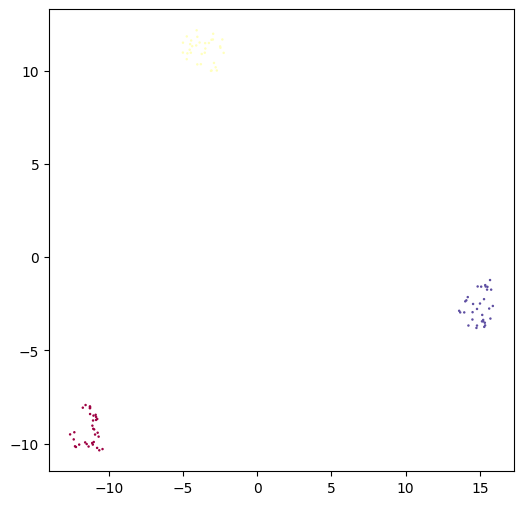

In [3]:
# initializing the pacmap instance
# Setting n_neighbors to "None" leads to an automatic choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(X, init="pca")

# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=y, s=0.6)

In [7]:
embedding.transform(X*2, basis=X)

array([[ 14.522537 ,  -2.4231167],
       [ 14.760947 ,  -2.5488222],
       [ 14.983173 ,  -2.7196372],
       [-11.052016 ,  -9.761924 ],
       [ -3.9366643,  11.281354 ],
       [ 14.898793 ,  -2.8463619],
       [ -4.5757318,  11.343062 ],
       [ -4.5757327,  11.343061 ],
       [ 15.224875 ,  -2.3603597],
       [ -4.5757318,  11.343062 ],
       [-11.074902 ,  -9.718701 ],
       [-11.242196 ,  -9.837603 ],
       [-11.177533 ,  -9.8698225],
       [ -4.5757327,  11.343061 ],
       [ 15.004303 ,  -2.685898 ],
       [-11.070702 ,  -9.921215 ],
       [-11.031492 ,  -9.603006 ],
       [ 14.527227 ,  -2.5120075],
       [-11.146766 ,  -9.532513 ],
       [ 14.586111 ,  -2.4440212],
       [ 14.664809 ,  -2.9630704],
       [ 14.570836 ,  -2.8299773],
       [-11.131973 ,  -9.709583 ],
       [-11.070702 ,  -9.921215 ],
       [ 14.781629 ,  -2.668578 ],
       [ 14.586111 ,  -2.4440212],
       [ 14.682197 ,  -2.7698903],
       [ 14.527228 ,  -2.512007 ],
       [ -4.338963 ,

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from metabolic_niche_space.neighbors import KNeighborsKernel
from metabolic_niche_space.manifold import DiffusionMapEmbedding # Shortcut: from datafold.dynfold import DiffusionMaps

# Create dataset
n_samples = 1000
n_neighbors=int(np.sqrt(n_samples))
X, y = make_classification(n_samples=n_samples, n_features=10, n_classes=2, n_clusters_per_class=1, random_state=0)
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3)

# Build KNeighbors Kernel
kernel = KNeighborsKernel(metric="euclidean", n_neighbors=30)

# Calculate Diffusion Maps using KNeighbors
model = DiffusionMapEmbedding(
    kernel=kernel, 
    n_eigenpairs=int(np.sqrt(X_training.shape[0])), # Upper bound
) 
dmap_X = model.fit_transform(X_training)
dmap_Y = model.transform(X_testing)

# Shapes
print(dmap_X.shape, dmap_Y.shape)
# (700, 26) (300, 26)

(700, 26) (300, 26)


In [11]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from metabolic_niche_space.neighbors import (
    KNeighborsKernel,
    pairwise_distances_kneighbors,
)
from metabolic_niche_space.manifold import DiffusionMapEmbedding # Shortcut: from datafold.dynfold import DiffusionMaps

# Load real boolean data and create toy dataset
n_observations = 500

X_grouped = pd.read_csv("../test/X_grouped.tsv.gz", sep="\t", index_col=0) > 0
X_toy = X_grouped.iloc[:n_observations]
X_training, X_testing = train_test_split(X_toy, test_size=0.3)

# Precompute pairwise distances
metric="jaccard"

distances = pairwise_distances_kneighbors(
    X=X_training, 
    metric=metric, 
    n_jobs=-1, 
    redundant_form=True,
)

# Build KNeighbors Kernel with precomputed distances
kernel = KNeighborsKernel(
    metric=metric, 
    n_neighbors=50, 
    distance_matrix=distances.values,
)

# Calculate Diffusion Maps using KNeighbors
model = DiffusionMapEmbedding(kernel=kernel, n_eigenpairs=int(np.log(X_training.shape[0]))) # Lower bound since it's sparse
dmap_X = model.fit_transform(X_training)
dmap_Y = model.transform(X_testing)
dmap_X.shape, dmap_Y.shape
# ((350, 5), (150, 5))


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from metabolic_niche_space.neighbors import (
    KNeighborsLeidenClustering,
)

# Load real boolean data and create toy dataset
n_observations = 500

X_grouped = pd.read_csv("../test/X_grouped.tsv.gz", sep="\t", index_col=0) > 0
X_toy = X_grouped.iloc[:n_observations]
X_training, X_testing = train_test_split(X_toy, test_size=0.3)

# Precompute pairwise distances
metric="jaccard"

distances = pairwise_distances_kneighbors(
    X=X_training, 
    metric=metric, 
    n_jobs=-1, 
    redundant_form=True,
)

# Determine parameter range
n = distances.shape[0]
n_neighbors_params = [int, int(np.log(n)), int(np.sqrt(n)/2)]

# Bayesian-optimized KNN Leiden Clustering
clustering = KNeighborsLeidenClustering(
    name="jaccard_similarity_clustering", 
    feature_type="ko", 
    observation_type="ani-cluster", 
    class_type="LeidenCluster", 
    n_neighbors=n_neighbors_params, 
    n_trials=5, 
    n_jobs=-1,
)
clustering.fit(distances)

NameError: name 'is_square_symmetric' is not defined